<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/BSE_Advance_Decline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install quandl

In [2]:
import quandl
import pandas as pd
import numpy as np
import requests
from quandl.errors.quandl_error import NotFoundError
import matplotlib.pyplot as plt

In [3]:
#@title Download from BSE
def download_from_BSE(datadump,startdate):
    data= {}
    df=pd.DataFrame()
    
    print(f'len of datadump {len(datadump)}')
    try:
      for i in range(len(datadump)):
          data[datadump[i]]= quandl.get('BSE/BOM'+datadump[i],start_date=startdate,authtoken="1Mz3xLNFNdUpKENCkArB")['Close']
          
          
      i=0
      for key , value in data.items():
        df.insert(i, key, value)
        i=i+1
    except NotFoundError:
      pass

    return df

In [4]:
#@title Rejected Scrips
rejectlst= ['543253','543213','543210','543233','543252','543249','543212','543242','543248','543066','543232','542759','543223','543238',\
            '543243','543235','543245','543220','543237','543240','543227','543228']

In [5]:
#@title Sectors
def get_bse_sector_list(data):
  url_github='https://raw.githubusercontent.com/anirbanghoshsbi/data/main/'
  files= {1:'IT.txt',2:'Manufacturing.txt',3:'auto.txt',4:'bankex.txt',5:'basic_materials.txt',6:'capital_goods.txt',\
        7:'consumer_discretion.txt',8:'consumer_durables.txt',9:'energy.txt',10:'finance.txt',11:'fmcg.txt',\
        12:'healthcare.txt',13:'industrials.txt',14:'infrastructure.txt',15:'low_volatility.txt',16:'media.txt',\
        17:'metals.txt',18:'midcap_select.txt',19:'momentum.txt',20:'private_sector_bank.txt',21:'public_sector_bank.txt',\
        22:'telecom.txt',23:'oil_and_gas.txt',24:'utilities.txt',25:'power.txt',26:'reality.txt',27:'teck.txt',\
        }
  if data=='Momentum':
    url=url_github+files[19]
  if data=='Low Vol':
    url=url_github+files[15]
  if data == 'Basic Materials':
    url=url_github+files[5]
  if data=='Energy':
    url =url_github+files[9]
  if data== 'Consumer Discretion':
    url = url_github+files[7]
  if data== 'FMCG':
    url = url_github+files[11]
  if data == 'Finance':
    url = url_github+files[10]
  if data== 'Healthcare':
    url = url_github+files[12]
  if data=='Industrials':
    url = url_github+files[13] 
  if data=='IT':
    url = url_github+files[1]  
  if data == 'Telecom':
    url =  url_github+files[22]
  if data == 'Utilities':
    url = url_github+files[24]
  if data == 'Auto':
    url = url_github+files[3]
  if data =='Bankex':
    url = url_github+files[4]
  if data=='Capital Goods':
    url = url_github+files[6]             
  if data=='Consumer Durables':
    url = url_github+files[8]
  if data=='Metals':
    url = url_github+files[17]
  if data=="Oil and Gas":
    url = url_github+files[23] 
  if data=='Power':
    url =  url_github+files[25]   
  if data=='Reality':
    url = url_github+files[26] 
  if data=='Teck':
    url = url_github+files[27]
  if data=='PSU Bank':
    url =  url_github+files[21]
  if data=='Private Bank':
    url =  url_github+files[20] 
  if data=='Manufacturing':
    url =  url_github+files[2]
  if data=='Consumer Durables':
    url =  url_github+files[8]
  if data=='Infrastructure':
    url =  url_github+files[14]
  if data=='Media':
    url =  url_github+files[16] 
  dataframe = pd.read_csv(url,sep='\t') 
  scrip_code=dataframe['Scrip Code'].tolist()
  scrip_code = [str(i) for i in scrip_code]
  return scrip_code

In [6]:
#@title Feature Engineering
def do_feature_engineering(datadump,startdate,rejectlst=rejectlst):
  datadump=[i for i in datadump if i not in rejectlst]
  data=download_from_BSE(datadump,startdate)
  global data_copy
  data_copy=data.copy()
  
  print(data.shape)
  for i in range(len(data.iloc[0])):
    
    varname = 'ema_'+str(i)
    data[varname]=data[data.columns[i]]-data[data.columns[i]].rolling(window=50).mean()
  new_df = data.loc[:, ~data.columns.isin(data_copy.columns.tolist())]  
  new_df=new_df.mask(new_df>0,1)
  new_df=new_df.mask(new_df<=0,0)
  above_50_dma=new_df.sum(axis=1) 
  Ad_dataframe=pd.DataFrame(above_50_dma)
  Ad_dataframe.columns=['sum']
  Ad_dataframe['macd']=Ad_dataframe['sum'].ewm(span=20, adjust=False).mean()-Ad_dataframe['sum'].ewm(span=50, adjust=False).mean()
  Ad_dataframe['signal']=Ad_dataframe['macd'].ewm(span=15,adjust=False).mean()
  Ad_dataframe['hist']=Ad_dataframe['macd']-Ad_dataframe['signal']  
  return Ad_dataframe

In [7]:
#@title Draw Plot
def draw_plot(labels,df,nifty,buy,sell):
  fig, ax = plt.subplots(3,1, figsize=(15,9),sharex=True)
  ax[0].plot(df.loc[:, :].index, df.loc[:, 'sum'], label=labels)
  ax[2].plot(nifty.loc[:, :].index, nifty.loc[:, 'Close'], label='Nifty')
  ax[2].scatter(nifty.iloc[buy].index,nifty.iloc[buy].Close,marker='^',label='Buy',color='g')
  ax[2].scatter(nifty.iloc[sell].index,nifty.iloc[sell].Close,marker='v',label='Sell',color='r')
  ax[2].plot(nifty['Close'].ewm(span=50,adjust=False).mean())
  ax[0].plot(df['sum'].ewm(span=50, adjust=False).mean(),linewidth=2, markersize=4 ,label='50EMA' ,color='r')
  ax[0].plot(df['sum'].ewm(span=20, adjust=False).mean(),linewidth=1, markersize=4 ,label='20EMA' ,color='g')
  ax[1].plot(df['macd'],label='MACD')
  ax[1].plot(df['signal'],label='Signal')
  #ax[1].hist(df['hist'],label='Histogram')
  ax[0].legend(loc='upper left')
  ax[0].set_ylabel(labels)
  ax[1].legend('MACD')
  ax[1].legend(loc='upper left')
  ax[2].legend('Nifty')
  #ax[0].axhline(y=50 , color ='r')
  #ax[0].axhline(y=80 , color ='c')
  #ax[0].axhline(y=40 , color ='b')
  #ax[0].axhline(y=20 , color ='g')
  ax[1].axhline(y=0 , color='r')
  fig.suptitle(labels)
  plt.show()

In [8]:
#@title plot buy sell signal
def plot_buy_sell_signal(df):
  buy=[]
  sell=[]
  for i in range(len(df)):
    if df.macd.iloc[i]>df.signal.iloc[i] and df.macd.iloc[i-1]<df.signal.iloc[i-1] :
      buy.append(i)
    elif df.macd.iloc[i]<df.signal.iloc[i] and df.macd.iloc[i-1]>df.signal.iloc[i-1]:
      sell.append(i)
  
  return buy ,sell

In [9]:
startdate='2019-01-01'


# Fill The Column Below

In [10]:
#@title Get All Data
def get_all_in_one(data,index,startdate,rejectlst=rejectlst):
  print('datadump')
  datadump=get_bse_sector_list(data) ##### Only Fill This part ##########
  nifty=quandl.get('BSE/'+ index,start_date=startdate, authtoken="1Mz3xLNFNdUpKENCkArB")
  df_fin_eng=do_feature_engineering(datadump,startdate,rejectlst=rejectlst)
  buy,sell=plot_buy_sell_signal(df_fin_eng)
  d=nifty.reset_index()
  b=buy[-1:] 
  s=sell[-1:]
  print(f' ----------------')
    
  if b>s:
    print(f'|Buy : {data}   |')
    print(f'|{str(d.iloc[b].Date.values[0])[:10]}     |')
    print(f'|{d.iloc[b].Close.values.tolist()[0]}       |')
  if s>b:
    print(f'|Sell : {data}    |')
    print(f'|{str(d.iloc[s].Date.values[0])[:10]}     |')
    print(f'|{d.iloc[s].Close.values.tolist()[0]}       |')
  print(f' ----------------')  
  lbls= 'Above 50 EMA : '+str(data)
  draw_plot(lbls,df_fin_eng,nifty,buy,sell)


In [11]:
lst=['Momentum','Metals',"Oil and Gas",'Bankex','Power','Reality','Telecom','Utilities','Auto','Healthcare','IT','Industrials','Finance']
ind=['SPBSMOIP','SI1200','SI1400','SIBANK','SIPOWE','SIREAL','SPBSTLIP','SPBSUTIP','SI1900','SI0800','SI1000','SPBSIDIP','SPBSFIIP']

datadump
len of datadump 30
(325, 30)
 ----------------
|Sell : Momentum    |
|2020-03-27     |
|628.72       |
 ----------------


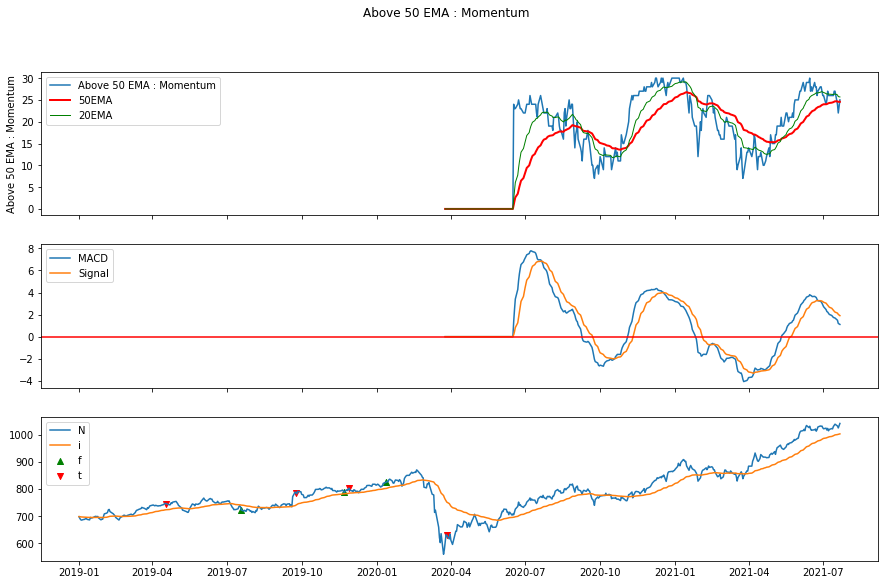

datadump
len of datadump 10
(634, 10)
 ----------------
|Sell : Metals    |
|2021-06-17     |
|18429.51       |
 ----------------


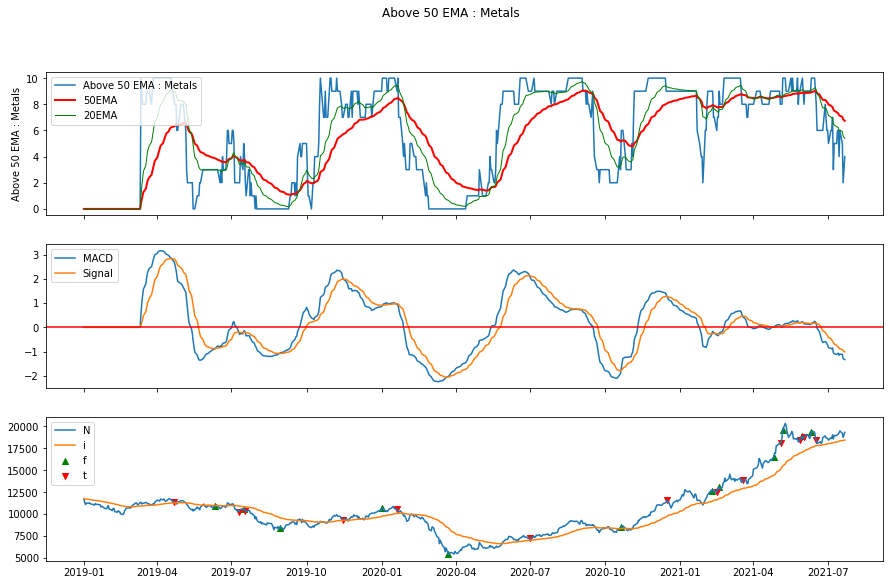

datadump
len of datadump 10
(634, 10)
 ----------------
|Sell : Oil and Gas    |
|2021-06-21     |
|17065.17       |
 ----------------


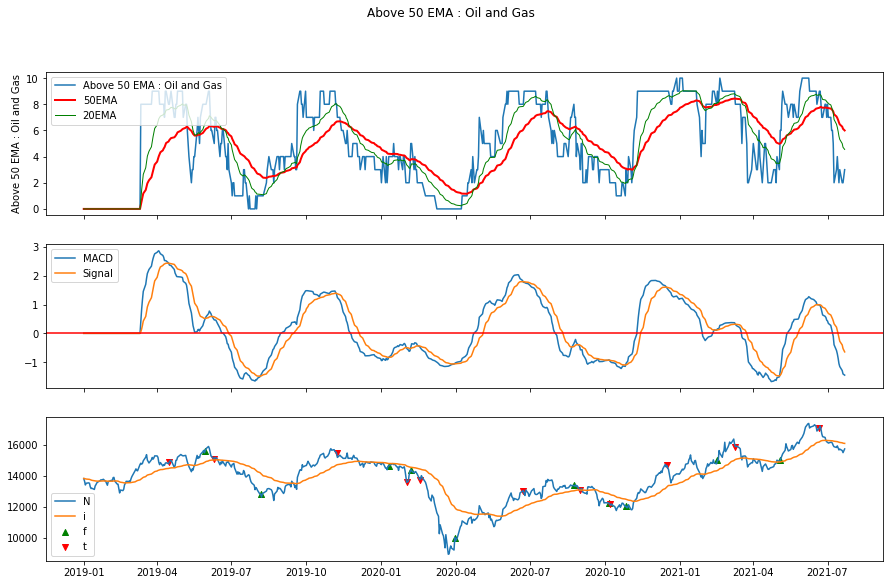

datadump
len of datadump 10
(634, 10)
 ----------------
|Sell : Bankex    |
|2021-06-30     |
|39349.98       |
 ----------------


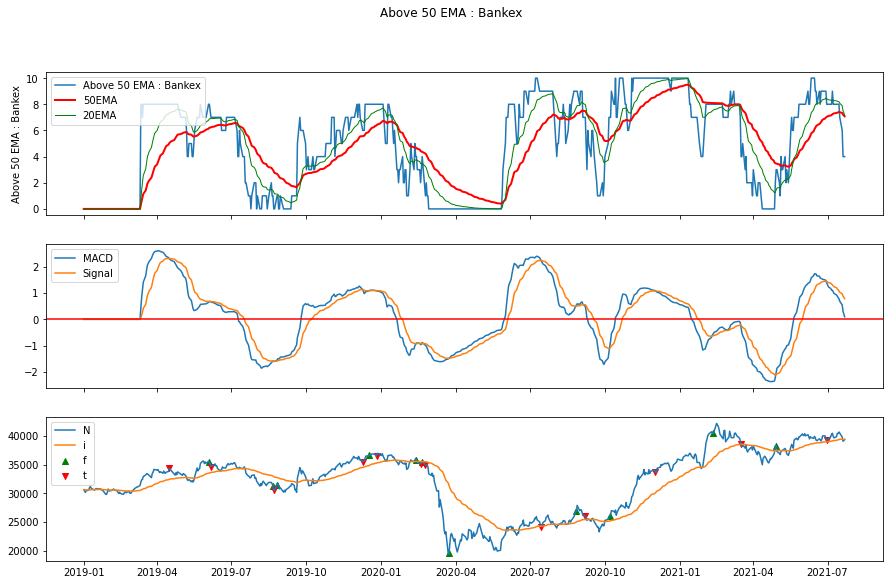

datadump
len of datadump 10
(634, 10)
 ----------------
|Sell : Power    |
|2021-06-21     |
|2832.58       |
 ----------------


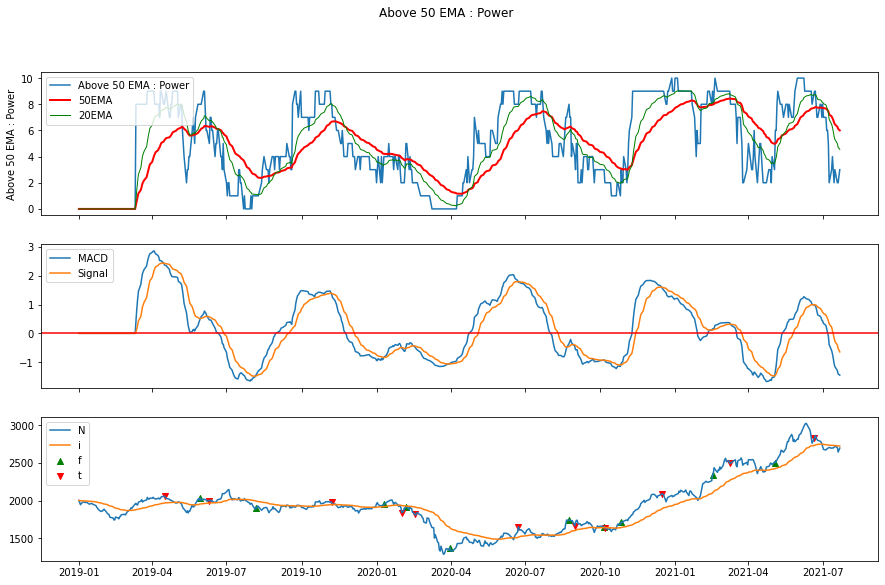

datadump
len of datadump 10
(634, 10)
 ----------------
|Sell : Reality    |
|2021-06-30     |
|2740.68       |
 ----------------


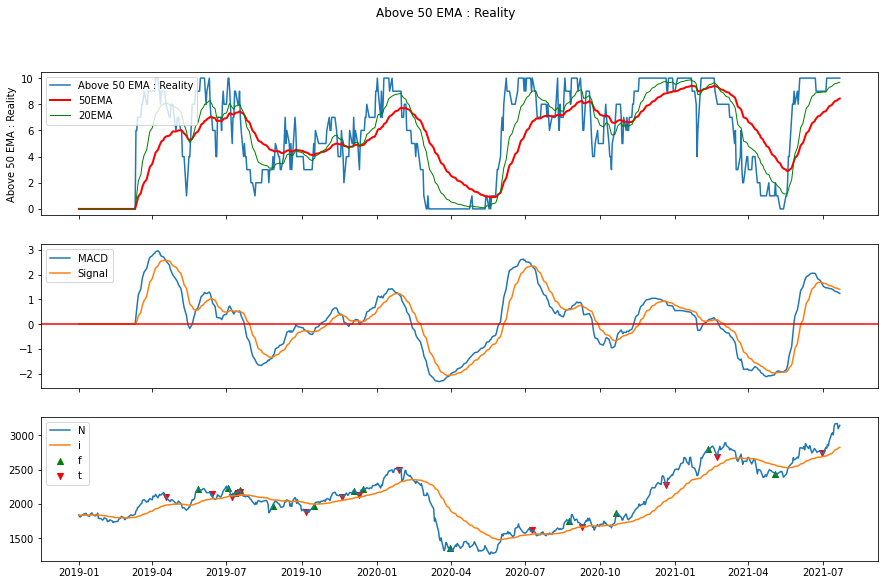

datadump
len of datadump 13
(634, 13)
 ----------------
|Buy : Telecom   |
|2021-07-22     |
|1416.35       |
 ----------------


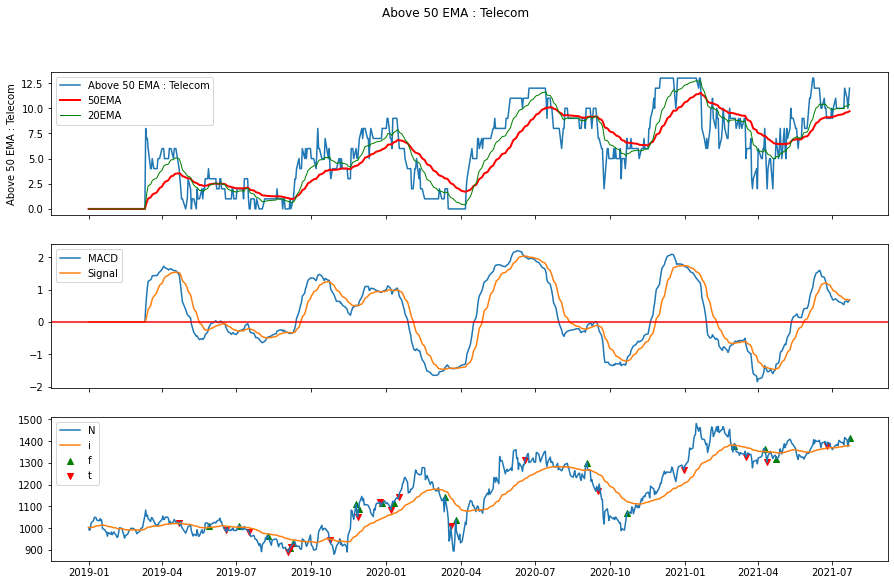

datadump
len of datadump 26
(634, 26)
 ----------------
|Sell : Utilities    |
|2021-06-22     |
|2567.4       |
 ----------------


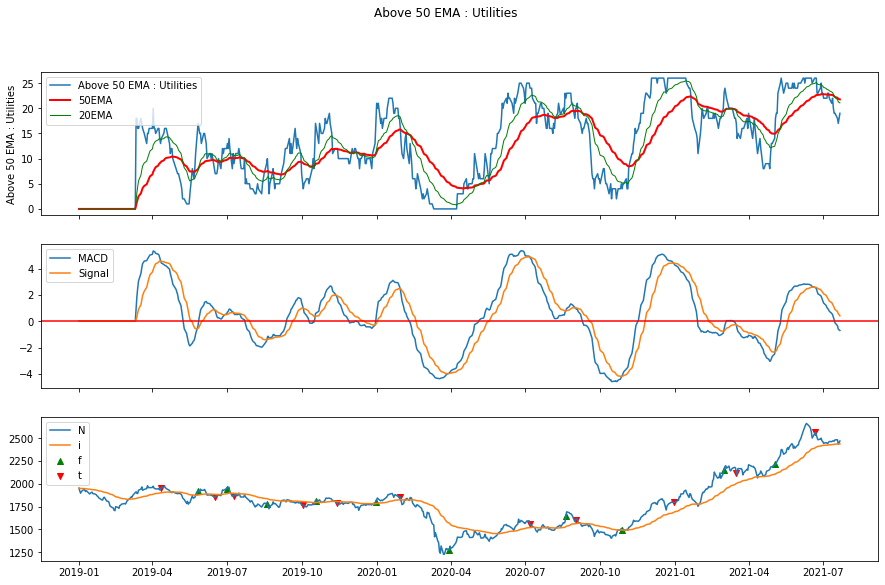

datadump
len of datadump 15
(634, 15)
 ----------------
|Sell : Auto    |
|2021-06-21     |
|23267.37       |
 ----------------


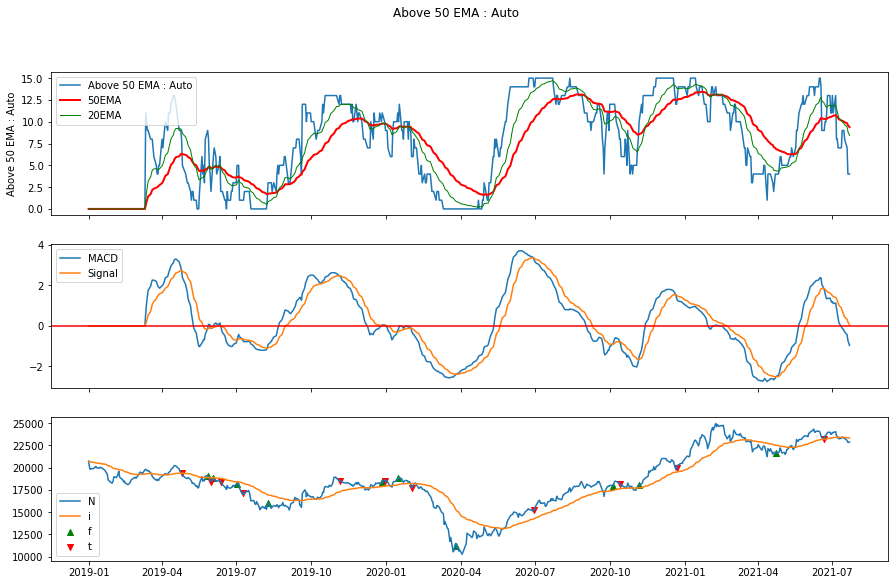

datadump
len of datadump 68
(634, 68)
 ----------------
|Sell : Healthcare    |
|2021-05-21     |
|24474.37       |
 ----------------


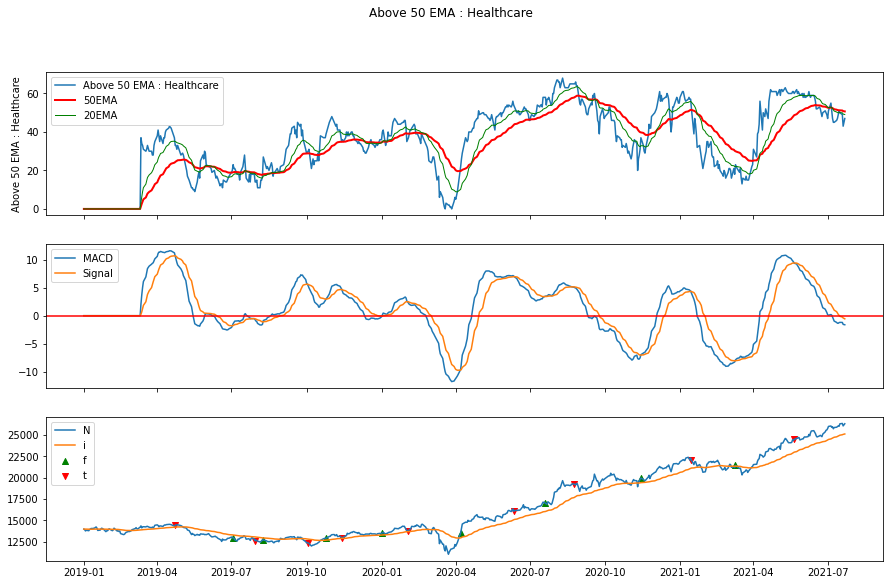

datadump
len of datadump 50
(634, 50)
 ----------------
|Sell : IT    |
|2021-06-28     |
|29922.19       |
 ----------------


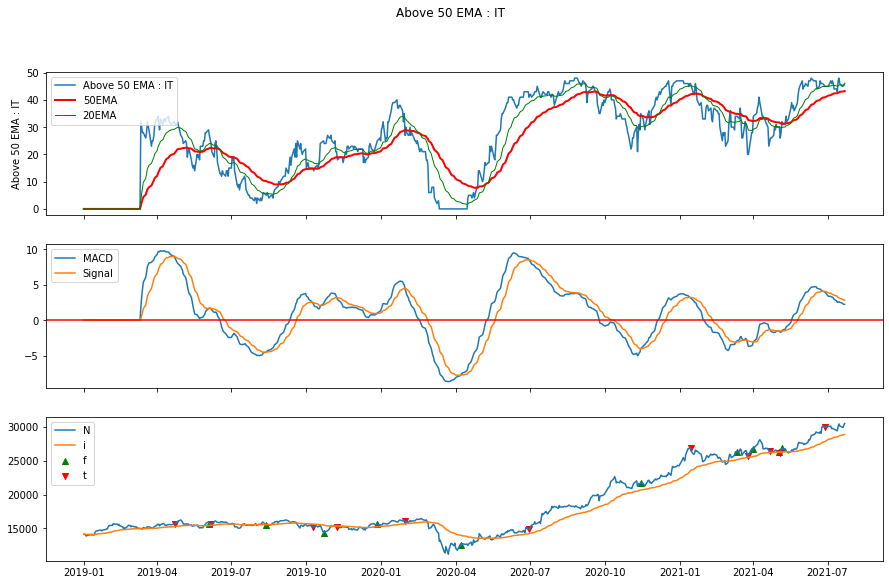

datadump
len of datadump 179
(634, 179)
 ----------------
|Sell : Industrials    |
|2021-06-24     |
|4688.88       |
 ----------------


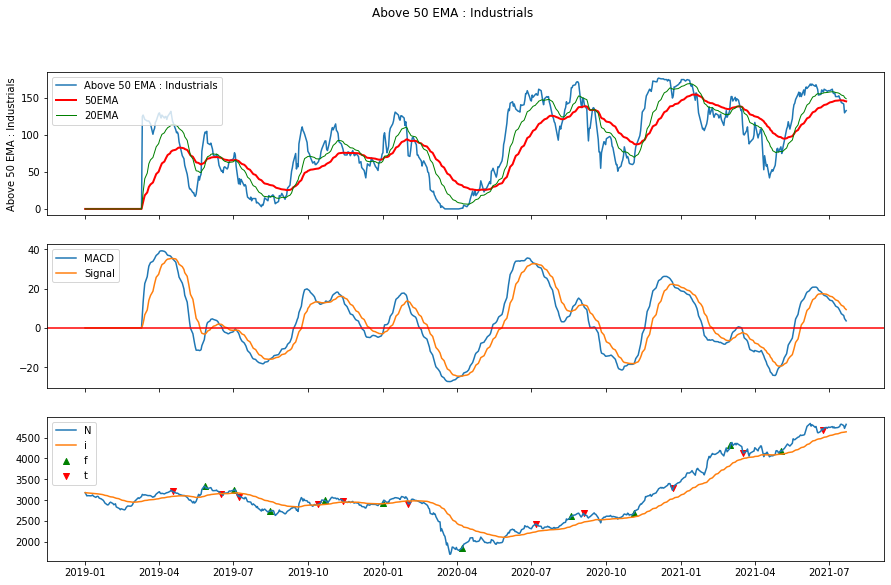

datadump
len of datadump 103
(634, 103)
 ----------------
|Sell : Finance    |
|2021-06-24     |
|7764.9       |
 ----------------


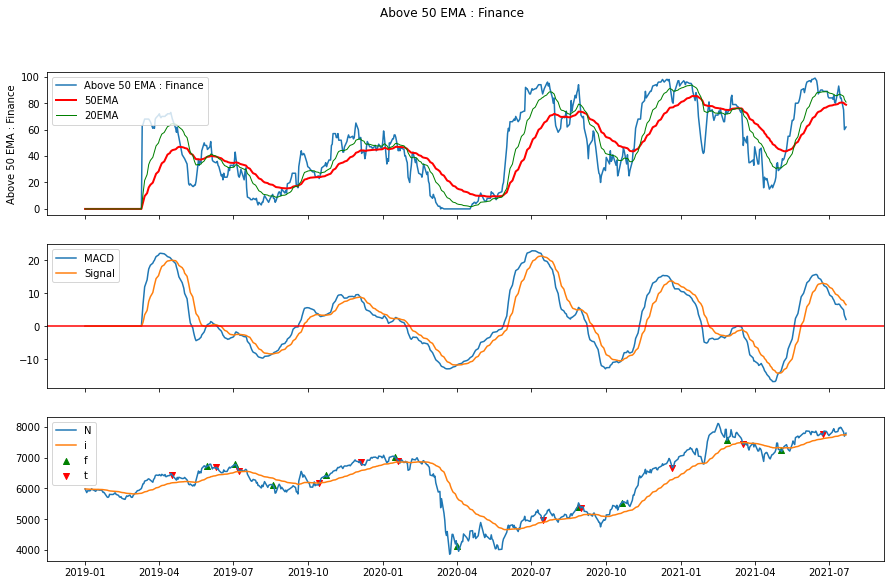

In [12]:
for data, index in zip(lst,ind):
  get_all_in_one(data,index,startdate,rejectlst=rejectlst)
  

In [13]:
nifty=quandl.get('BSE/'+ index,start_date=startdate, authtoken="1Mz3xLNFNdUpKENCkArB")

In [14]:
nifty.tail(1)

,Open,High,Low,Close
Date,,,,
2021-07-22,7750.9,7830.64,7749.88,7793.57
